In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
from iminuit import Minuit
from scipy import stats
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import chi2
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path, 0)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,
Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [3]:
APS_dict_keys = ['20241016_APS', '20241016_APS_2_exp', '20241017_APS', '20241017_APS']
APS_bins = OPS_APS['20241016_APS'].keys()[1:53].to_list()
APS_bin_mean = [(0.486968 + 0.523)/2]
for key in OPS_APS['20241016_APS'].keys()[2:53]:
    APS_bin_mean.append(float(key))
    OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce') * 1.2
APS_cut_point = np.concatenate(([0.486968], (np.array(APS_bin_mean)[1:]+np.array(APS_bin_mean)[:-1])/2, [20.53]))

APS_mass_conc = {}
APS_mass_conc['20241016_APS'] = OPS_APS['20241016_APS']
for key in APS_dict_keys[1:3]:
    for i, bin in enumerate(APS_bins):
        bin_width = np.log10(APS_cut_point[i+1]) - np.log10(APS_cut_point[i])
        OPS_APS[key][bin] = pd.to_numeric(OPS_APS[key][bin]) * bin_width
    mass_conc = calc_mass_conc(OPS_APS[key], APS_bins, APS_bin_mean, 1.2)
    APS_mass_conc[key] = mass_conc

APS_number = pd.DataFrame({'Time': OPS_APS['20241016_APS']['Time']})
for i, key in enumerate(APS_bins):
        # Ensure df[key] is numeric
        OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce')
        
        APS_number[key] = OPS_APS['20241016_APS'][key] / ((1.2 / 10**6) * (np.pi / 6) * APS_bin_mean[i]**3 * 10**6) # in #/cm**3
OPS_APS['20241016_APS'] = APS_number

SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_bins = SMPS['20241016_SMPS'].keys()[4:117].to_list()
SMPS_bin_mean = []
for key in SMPS['20241016_SMPS'].keys()[4:117]:
    SMPS_bin_mean.append(float(key) / 1000)
SMPS_cut_point = np.concatenate(([0.017], (np.array(SMPS_bin_mean)[1:]+np.array(SMPS_bin_mean)[:-1])/2, [1.0]))

for key in SMPS_dict_keys[:3]:
    for i, bin in enumerate(SMPS_bins):
        bin_width = np.log10(SMPS_cut_point[i+1]) - np.log10(SMPS_cut_point[i])
        SMPS[key][bin] = pd.to_numeric(SMPS[key][bin]) * bin_width

In [4]:
timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

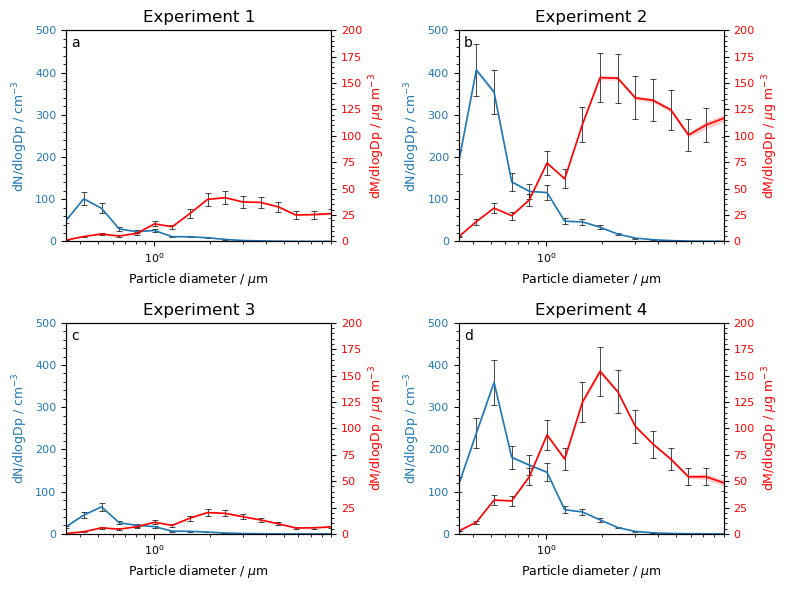

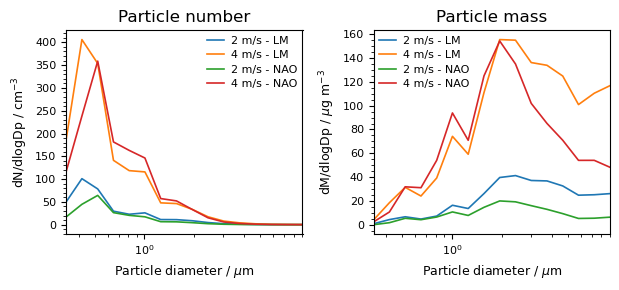

In [5]:
OPS_dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

OPS_mass_conc = {}
for key in OPS_dict_keys:
    mass_conc = calc_mass_conc(OPS_APS[key], OPS_bins, OPS_mid_point, 1.2)
    OPS_mass_conc[key] = mass_conc

OPS_mean_conc, OPS_axes, OPS_figs = plot_mean_all(timestamps_exp, OPS_APS, OPS_mass_conc, OPS_dict_keys, OPS_bins, OPS_mid_point, OPS_cut_point, 0.15, [500, 200])

OPS_figs[0].savefig('Mean_concentrations/OPS_mean.png', dpi = 600)
OPS_figs[1].savefig('Mean_concentrations/OPS_mean_all.png', dpi = 600)

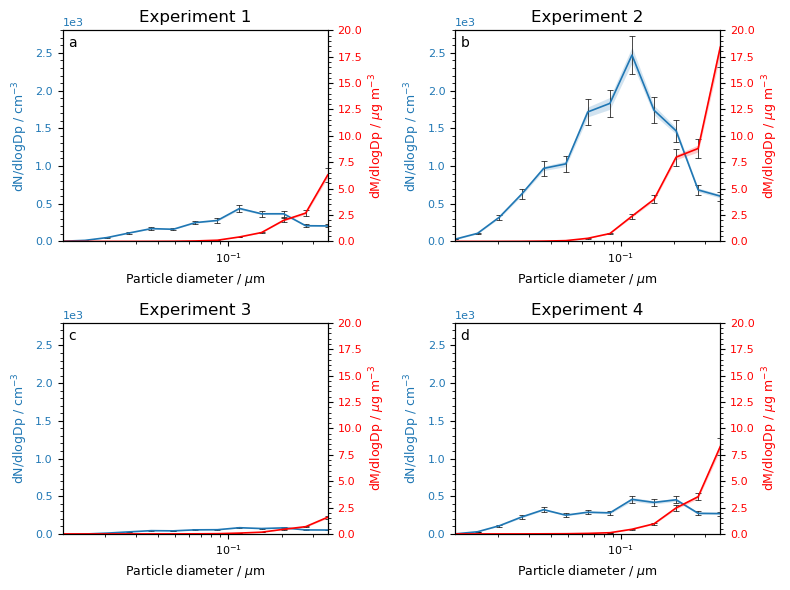

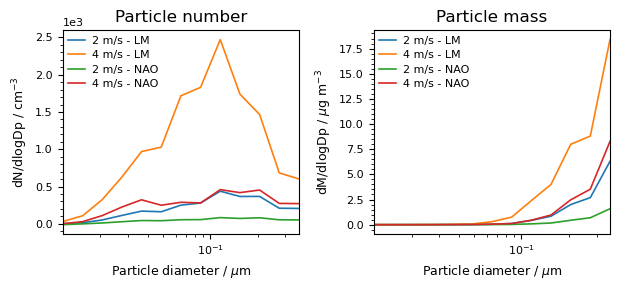

In [6]:
NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NanoScan_bin_mean = []
for key in SMPS['2024-10-16_NanoScan'].keys()[3:16]:
    NanoScan_bin_mean.append(float(key) / 1000)
NanoScan_Bins = SMPS['2024-10-16_NanoScan'].keys()[3:16].to_list()
NS_cut_point = bin_edges(0.010, NanoScan_bin_mean)

NS_mass_conc = {}
for key in NanoScan_dict_keys:
    mass_conc = calc_mass_conc(SMPS[key], NanoScan_Bins, NanoScan_bin_mean, 1.2)
    NS_mass_conc[key] = mass_conc

NS_mean_conc, NS_axes, NS_figs = plot_mean_all(timestamps_exp, SMPS, NS_mass_conc, NanoScan_dict_keys, NanoScan_Bins, NanoScan_bin_mean, NS_cut_point, 0.10, [2800, 20])

NS_figs[0].savefig('Mean_concentrations/NS_mean.png', dpi = 600)
NS_figs[1].savefig('Mean_concentrations/NS_mean_all.png', dpi = 600)

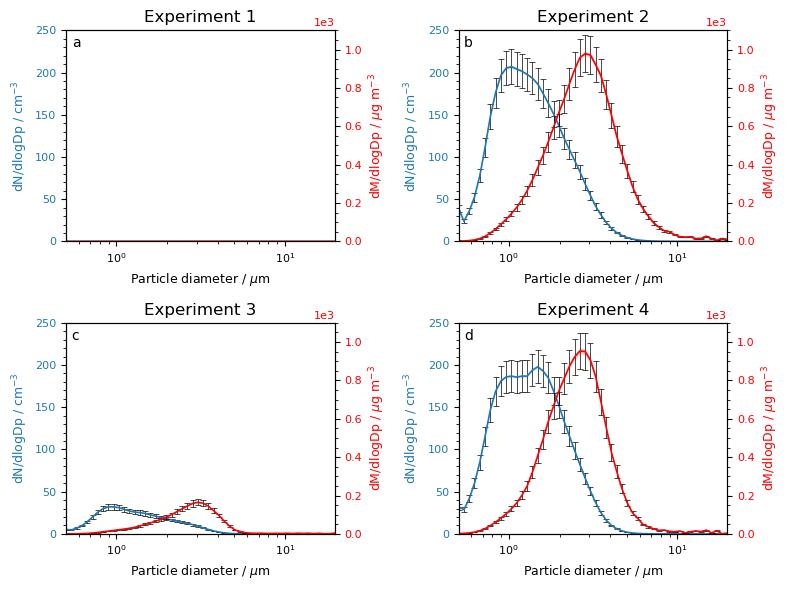

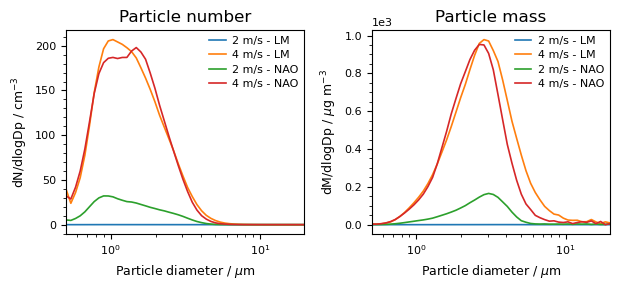

In [7]:
APS_mean_conc, APS_axes, APS_figs = plot_mean_all(timestamps_exp, OPS_APS, APS_mass_conc, APS_dict_keys, APS_bins, APS_bin_mean, APS_cut_point.tolist(), 0.10, [250, 1100])

APS_figs[0].savefig('Mean_concentrations/APS_mean.png', dpi = 600)
APS_figs[1].savefig('Mean_concentrations/APS_mean_all.png', dpi = 600)

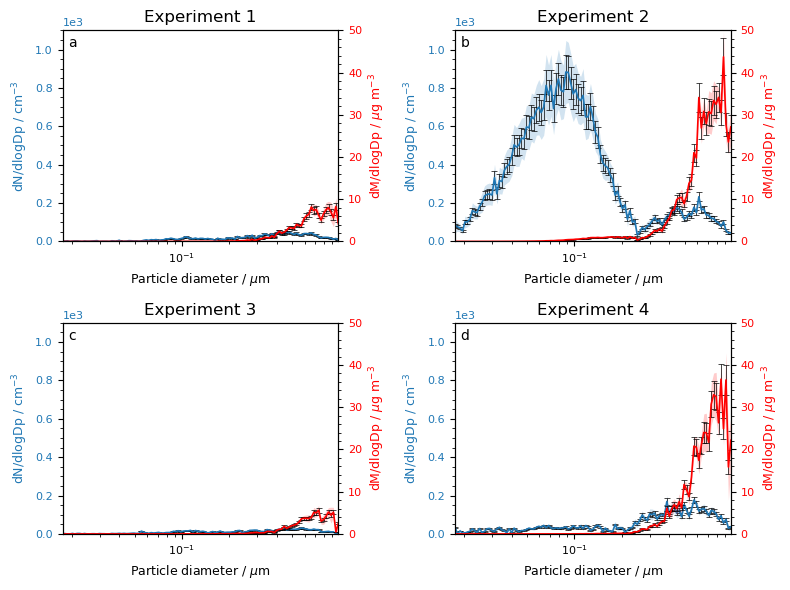

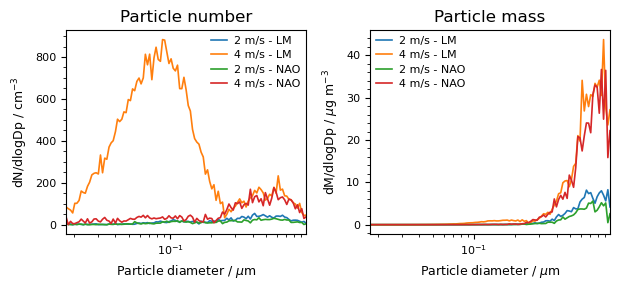

In [8]:
SMPS_mass_conc = {}
for key in SMPS_dict_keys:
    mass_conc = calc_mass_conc(SMPS[key], SMPS_bins, SMPS_bin_mean, 1.2)
    SMPS_mass_conc[key] = mass_conc

SMPS_mean_conc, SMPS_axes, SMPS_figs = plot_mean_all(timestamps_exp, SMPS, SMPS_mass_conc, SMPS_dict_keys, SMPS_bins, SMPS_bin_mean, SMPS_cut_point.tolist(), 0.10, [1100, 50])

SMPS_figs[0].savefig('Mean_concentrations/SMPS_mean.png', dpi = 600)
SMPS_figs[1].savefig('Mean_concentrations/SMPS_mean_all.png', dpi = 600)